# Seam Carving for context avare image resizing
---

This is naive realization of image resizing algorithm (dynamic programming). 

In [7]:
import os
import numpy as np
import scipy
import matplotlib.pyplot as plt
%matplotlib inline

from skimage.io import imread
from skimage.color import convert_colorspace
from skimage.filters import prewitt
from scipy.ndimage.interpolation import rotate
from time import time

In [8]:
img = imread(os.getenv('HOME') + '/Documents/cs/cvision/02-seam-carve/code/tests/pic_01.png')
mask = imread(os.getenv('HOME') + '/Documents/cs/cvision/02-seam-carve/code/tests/pic_01_mask.png')
mask = ((mask[:,:,0]!=0)*(-1) + (mask[:,:,1]!=0)).astype('int8')

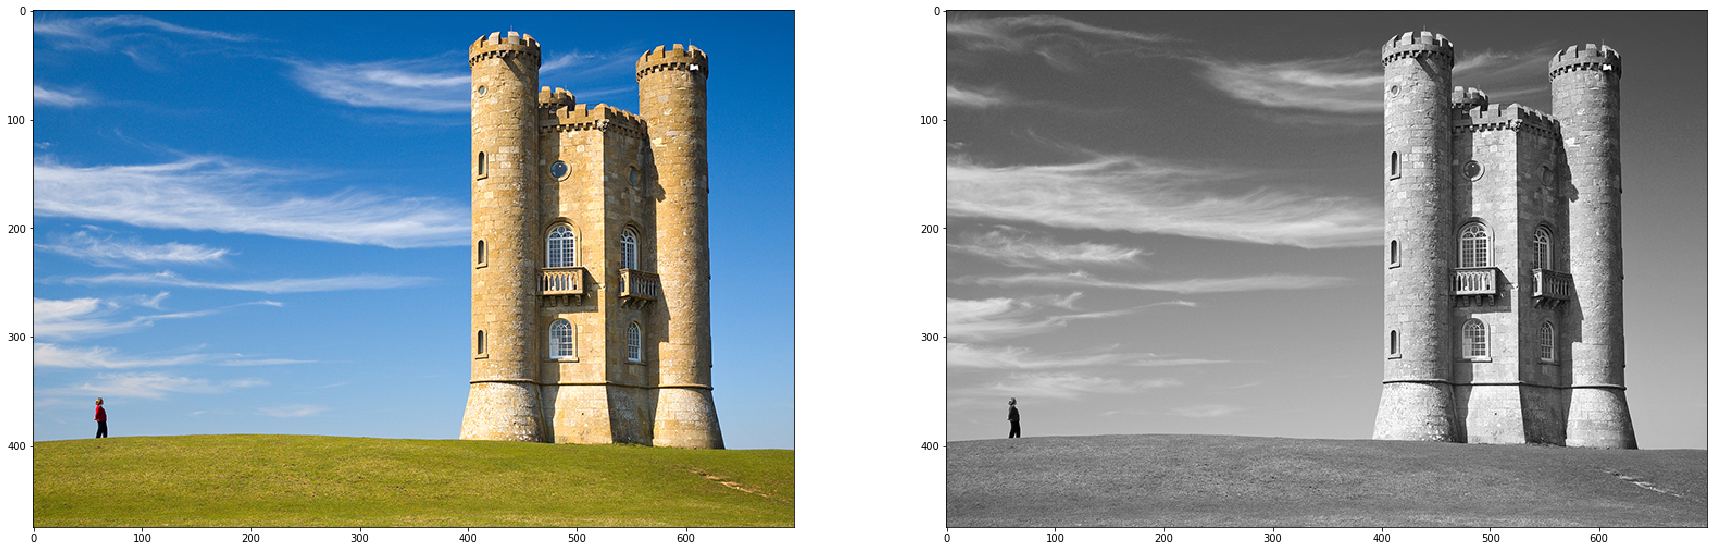

In [4]:
def get_brightness(img):
     return convert_colorspace(img, 'RGB', 'YUV')[:,:,0]
brightness = get_brightness(img)
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(30, 30))
ax1.imshow(img)
ax2.imshow(brightness, cmap='gray')

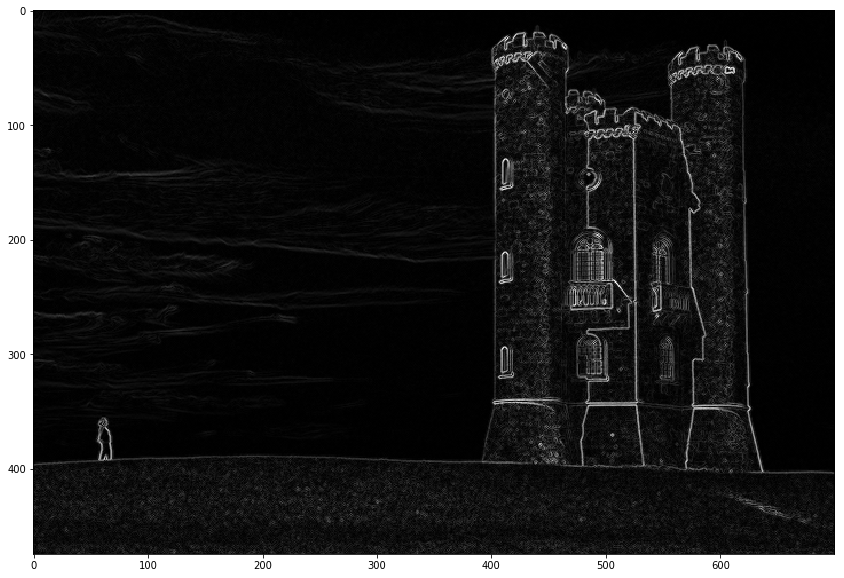

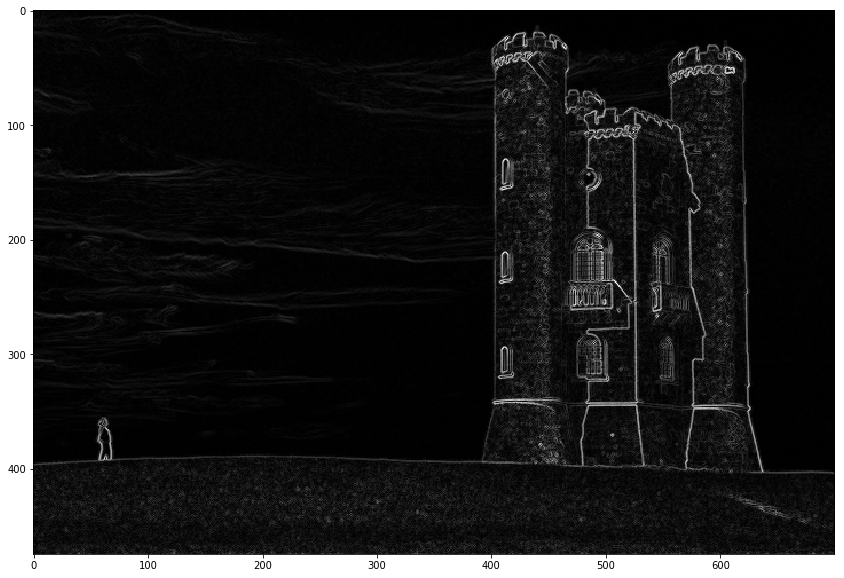

In [5]:
def get_energy(brightness, mask=None):
    img_energy = np.ones(brightness.shape)
    for x in range(brightness.shape[0]):
        for y in range(brightness.shape[1]):
            if x == 0:
                dx = brightness[1, y] - brightness[0, y]
            elif x == brightness.shape[0] - 1:
                dx = brightness[x, y] - brightness[x - 1, y]
            else:
                dx = brightness[x + 1, y] - brightness[x - 1, y]
            
            if y == 0:
                dy = brightness[x, 1] - brightness[x, 0]
            elif y == brightness.shape[1] - 1:
                dy = brightness[x, y] - brightness[x, y - 1]
            else:
                dy = brightness[x, y + 1] - brightness[x, y - 1]
            
            if mask is None or mask[x, y] == 0:
                img_energy[x][y] = np.sqrt(dx**2 + dy**2)
            elif mask[x, y] == 1:
                img_energy[x][y] = img.shape[0] * img.shape[1] * 256
            else:
                img_energy[x][y] = -img.shape[0] * img.shape[1] * 256
    return img_energy

img_energy = get_energy(brightness)
dy, dx = np.gradient(brightness)
img_energy1 = np.hypot(dx, dy)
# print(img_energy[0, 16], img_energy1[0, 16])
plt.figure(figsize=(30, 10))
plt.imshow(img_energy, cmap='gray')
plt.figure(figsize=(30, 10))
plt.imshow(img_energy1, cmap='gray')

In [6]:
def get_seam_coords(img_energy):
    dp_array = np.copy(img_energy)
    for x in range(1, dp_array.shape[0]):
        for y in range(dp_array.shape[1]):
            if y == 0:
                dp_array[x][y] += min(dp_array[x - 1][y], dp_array[x - 1][y + 1])
            elif y == dp_array.shape[1] - 1:
                dp_array[x][y] += min(dp_array[x - 1][y], dp_array[x - 1][y - 1])
            else:
                dp_array[x][y] += min(dp_array[x - 1][y], dp_array[x - 1][y - 1], dp_array[x - 1][y + 1])

    min_energy = dp_array[-1, -1]
    ind = dp_array.shape[1] - 1
    for y in range(dp_array.shape[1]):
        if dp_array[-1, y] < min_energy:
            min_energy = dp_array[-1, y]
            ind = y


    x = dp_array.shape[0] - 1
    y = ind

    seam = [(x, y)]

    while x != 0:
        for shift in (-1, 0, 1):
            if 0 <= y + shift <= dp_array.shape[1] - 1:
                if dp_array[x][y] == dp_array[x - 1][y + shift] + img_energy[x][y]:
                    x -= 1
                    y += shift
                    seam.append((x, y))
                    break
    return tuple(reversed(seam))

seam = get_seam_coords(img_energy)

In [10]:
def resize_image(img, seam, mode, mask=np.zeros(img.shape[:2], dtype='int8')):
    carve_mask = np.zeros(img.shape[0:2], dtype='uint8')
    if mode == 'shrink':
        resized_img = np.zeros((img.shape[0], img.shape[1] - 1, img.shape[2]), dtype='uint8')
        resized_mask = np.zeros((mask.shape[0], mask.shape[1] - 1), dtype='int8')
        for x in range(img.shape[0]):
            resized_img[x] = np.delete(img[x], seam[x][1], axis=0)
            carve_mask[seam[x]] = 1
            resized_mask[x] = np.delete(mask[x], seam[x][1])
    if mode == 'expand':
        resized_img = np.zeros((img.shape[0], img.shape[1] + 1, img.shape[2]), dtype='uint8')
        resized_mask = np.zeros((mask.shape[0], mask.shape[1] + 1), dtype='int8')
        for x in range(img.shape[0]):
            new_pixel = (img[seam[x]] / 2 + img[seam[x][0], seam[x][1] + 1] / 2)
            carve_mask[seam[x]] = 1
            resized_img[x] = np.insert(img[x], seam[x][1], new_pixel, axis=0)
            resized_mask[x] = np.insert(mask[x], seam[x][1], 0)
            resized_mask[seam[x]] = 1
    
    return resized_img, carve_mask, resized_mask

In [12]:
%%time
for i in range(10):
    resized_img, carve_mask, resized_mask = resize_image(img, seam, 'shrink', mask)
    img = resized_img
    brightness = get_brightness(img)
    img_energy = get_energy(brightness)
    seam = get_seam_coords(img_energy)

CPU times: user 19.9 s, sys: 156 ms, total: 20.1 s
Wall time: 20.2 s


## Enlarging an image
---
In order to enlarge image, we need to find the seam with lowest energy and add new seam to the right of it. We also need to increase the value of mask, because if we try to enlarge image multiple times we will have blured out image.

In [133]:
print(np.array([1, 2, 3]))

[1 2 3]


In [169]:
direction, mode = 'vertical shrink'.split(' ')

vertical
shrink


## Some fucking stupid testing
---


In [125]:
from pickle import load
file = open(os.getenv('HOME') + '/Documents/cs/cvision/seam-carve/code/tests/pic_01_seams', 'rb')
coords_test = load(file)
for i in range(len(seam)):
    if (coords_test[i] != seam[i]):
        pass
#         print(seam[i], coords_test[i])
